In [23]:
#Python Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For Pretty Plots
sns.set(style="whitegrid")

In [24]:
# Phase 1 : Data Cleaning and Merging
# Loading the dataset
Generation = pd.read_csv('../Data/Plant_1_Generation_Data.csv')
Weather = pd.read_csv('../Data/Plant_1_Weather_Sensor_Data.csv')

# Previewing the datasets
print("Generation Data:")
display(Generation.head())

print("Weather Data:")
display(Weather.head())

Generation Data:


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


Weather Data:


,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [ ]:
# Converting date/time columns - We are converting becuase the come as strings and we them as timestamps
Generation['DATE_TIME'] = pd.to_datetime(Generation['DATE_TIME'],format='%d-%m-%Y %H:%M')
Weather['DATE_TIME'] = pd.to_datetime(Weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

In [26]:
# Group generation data by timestamp
# Each timestamp in Generation data appears multiple times, once per Inverter.
# We are grouping all rows that share the same timestamp and summing up to get the total solar DC power at each moment in time.
# We create a new dataframe called solar output
solar_output = Generation.groupby('DATE_TIME')['DC_POWER'].sum().reset_index()
solar_output.rename(columns={'DC_POWER': 'Total_DC_Power'}, inplace=True)
display(solar_output.head())

,DATE_TIME,Total_DC_Power
0,2020-05-15 00:00:00,0.0
1,2020-05-15 00:15:00,0.0
2,2020-05-15 00:30:00,0.0
3,2020-05-15 00:45:00,0.0
4,2020-05-15 01:00:00,0.0


In [27]:
# Merging with Weather data.
# The aim is to predict total DC-Power based on Weather Conditions.
merged_data = pd.merge(solar_output, Weather, on='DATE_TIME')

# Inspecting the merged data
print("Merged Data:")
display(merged_data.head())

# You can decide to Rename the colums if you want
# merged_data.rename(columns={
    # 'AMBIENT_TEMPERATURE': 'Ambient_Temperature',
    # 'MODULE_TEMPERATURE': 'Module_Temperature',
    # 'IRRADIATION': 'Irradiation'
# }, inplace=True)

Merged Data:


,DATE_TIME,Total_DC_Power,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


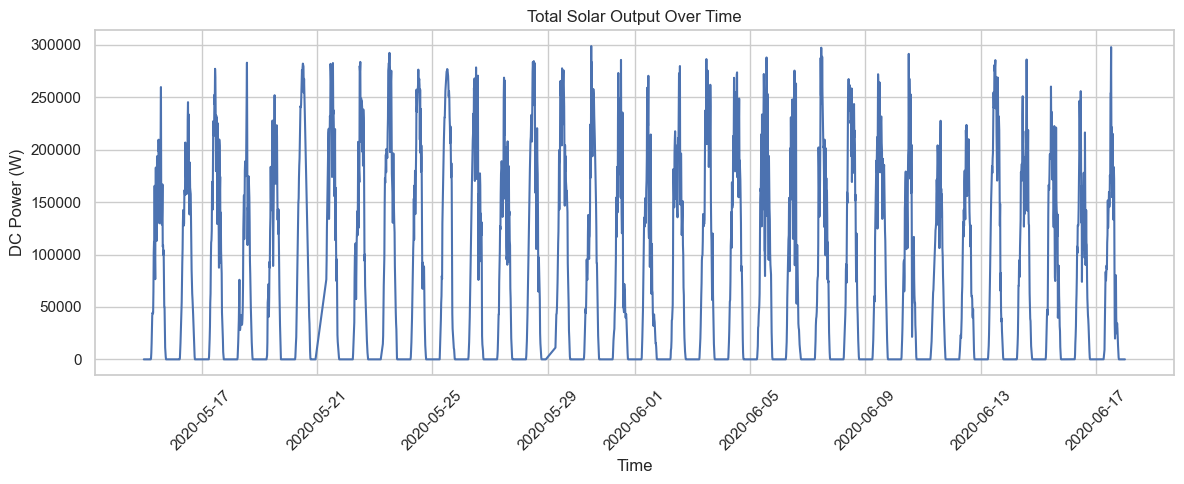

In [28]:
# Quick Explanatory Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=merged_data, x='DATE_TIME', y='Total_DC_Power')
plt.title('Total Solar Output Over Time')
plt.xlabel('Time')
plt.ylabel('DC Power (W)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Phase 2 : Feature Engineering + Exploratory Data Analysis (EDA)
# Step 1 : Adding time-based features - After converting the time from string to datetime, we can extract useful features.
# It will be better for our model to understand the time of day, day of week, etc. e.g Month = 5, Hour = 14, Day = 15, etc.
merged_data['Hour'] = merged_data['DATE_TIME'].dt.hour
merged_data['Day'] = merged_data['DATE_TIME'].dt.day
merged_data['Month'] = merged_data['DATE_TIME'].dt.month
merged_data['Day_Of_Week'] = merged_data['DATE_TIME'].dt.dayofweek

# Used when training the model....etc and making rolling averages.
# If you want to training using year, you can use rolling averages for years etc.

In [ ]:
# Step 2 : Adding Rolling Averages (Feature Engineering) - E.g. What's the average solar output over the last 2 hours?
# Rolling average of solar output over last 2 hours (8 Steps) - our data is in 15 minute intervals, so 8 steps = 2 hours
merged_data['dc_power_roll_avg'] = merged_data['Total_DC_Power'].rolling(window=8).mean()

# Rolling average of irradiance (how sunlight changes)
merged_data['irradiation_roll_avg'] = merged_data['IRRADIATION'].rolling(window=8).mean()

# You can also use .rolling(window=4).mean() for 1 hour average if you want etc.

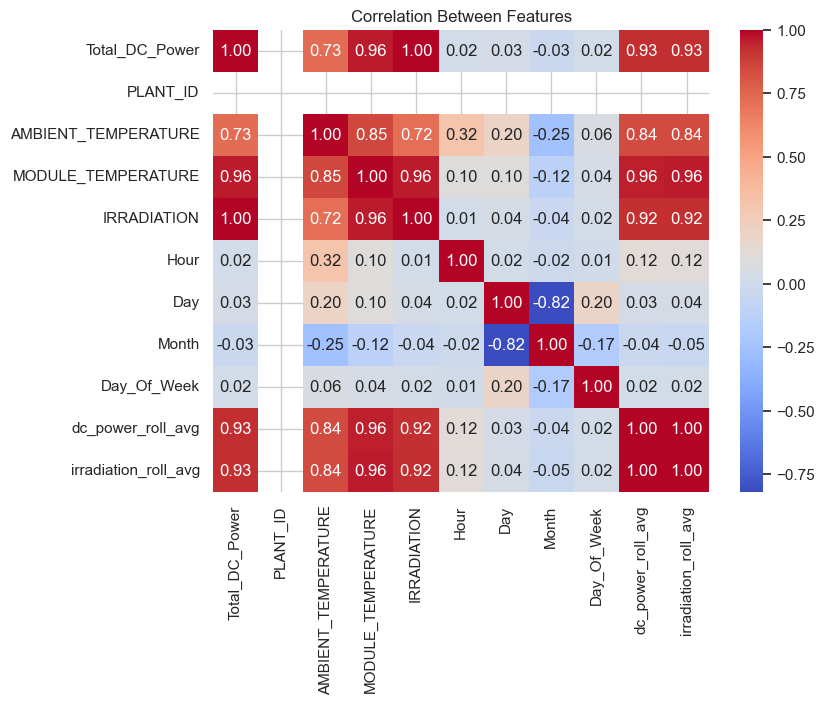

In [ ]:
# Step 3 : Explore the Relationships
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(merged_data.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Between Features')
plt.show()

# Which weather variable affects Total DC Power the most?
# Is Irradiace strongly correlated?

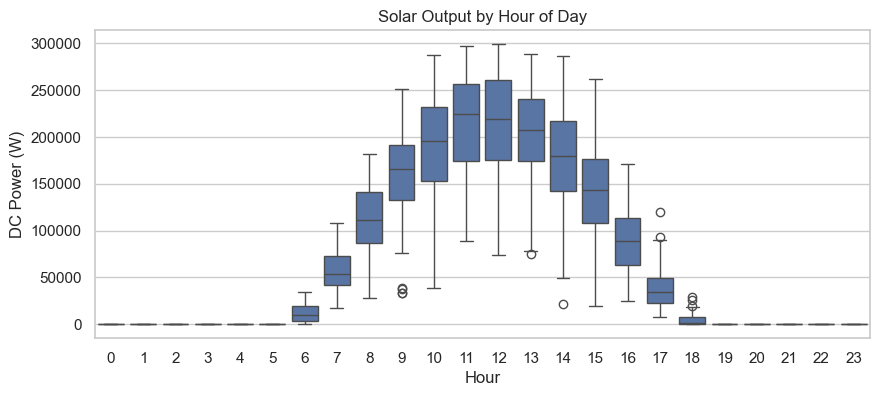

<Figure size 1000x1000 with 0 Axes>

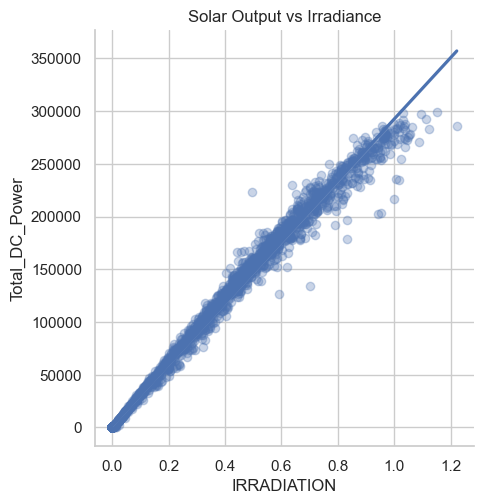

In [ ]:
# Step 4 : Distribution and Trend Plots
# Solar Output by Hour
plt.figure(figsize=(10, 4))
sns.boxplot(x='Hour', y='Total_DC_Power', data=merged_data)
plt.title('Solar Output by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('DC Power (W)')
plt.show()

# Output vs Irradiace
sns.lmplot(x='IRRADIATION', y='Total_DC_Power', data=merged_data, scatter_kws={'alpha':0.3})
plt.title('Solar Output vs Irradiance')
plt.show()


In [ ]:
# We ran this to see how the new features look like and verify no NaNs sneaked in.
merged_data.info()
merged_data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE_TIME             3157 non-null   datetime64[ns]
 1   Total_DC_Power        3157 non-null   float64       
 2   PLANT_ID              3157 non-null   int64         
 3   SOURCE_KEY            3157 non-null   object        
 4   AMBIENT_TEMPERATURE   3157 non-null   float64       
 5   MODULE_TEMPERATURE    3157 non-null   float64       
 6   IRRADIATION           3157 non-null   float64       
 7   Hour                  3157 non-null   int32         
 8   Day                   3157 non-null   int32         
 9   Month                 3157 non-null   int32         
 10  Day_Of_Week           3157 non-null   int32         
 11  dc_power_roll_avg     3150 non-null   float64       
 12  irradiation_roll_avg  3150 non-null   float64       
dtypes: datetime64[ns](

,DATE_TIME,Total_DC_Power,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,Hour,Day,Month,Day_Of_Week,dc_power_roll_avg,irradiation_roll_avg
count,3157,3157.000000,3157.0,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3150.000000,3150.000000
mean,2020-06-01 06:41:41.298701568,68560.019625,4135001.0,25.560257,31.175453,0.230103,11.626227,15.783022,5.515996,2.991764,68712.375224,0.230615
min,2020-05-15 00:00:00,0.000000,4135001.0,20.398505,18.140415,0.000000,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000
25%,2020-05-23 23:15:00,0.000000,4135001.0,22.739895,21.130249,0.000000,6.000000,9.000000,5.000000,1.000000,0.000000,0.000000
50%,2020-06-01 12:30:00,8430.196429,4135001.0,24.680324,24.801971,0.027748,12.000000,16.000000,6.000000,3.000000,14660.404018,0.049234
75%,2020-06-09 18:00:00,140409.892856,4135001.0,27.941221,41.449481,0.451576,18.000000,23.000000,6.000000,5.000000,143500.777902,0.467680
max,2020-06-17 23:45:00,298937.785710,4135001.0,35.252486,65.545714,1.221652,23.000000,31.000000,6.000000,6.000000,273497.625293,0.970735
std,NaN,88055.843520,0.0,3.351059,12.272685,0.301348,6.867083,8.561164,0.499823,2.053451,84253.178818,0.286846


In [43]:
# Saving the cleaned and merged data to a new CSV file 
merged_data.to_csv('Merged_data.csv', index=False)